<a href="https://colab.research.google.com/github/Emmnmm/sta365hw10/blob/main/Copy_of_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1
define : <br>
- Gaussian Processes (GPs) and stochastic processes generally <br>
- Variational inference using the Evidence Lower Bound (ELBO) <br>

A Stochastic process is a collection of random variables indexed by time or space, representing a system that evolves under uncertainty. Stochastic processes are widely used as mathematical models for systems and phenomena that appear to vary randomly, such as stock prices, weather patterns, and population growth. <br>
The Gaussian Processes (GPs) is a stochastic process where every finite collection of those random variables will follow a multivariate normal distribution, which makes GPs very flexible for modeling complex, non-linear relationships. The key properties of GPs are that it is defined by a mean function and a covariance (kernel) function. The kernel function determines how points influence each other, allowing GPs to model smooth, periodic, or non-stationary functions. <br>
We use Variational Inference (VI) because, in Bayesian inference, the posterior distribution is often too complex to compute directly. As our marginal likelihood p(x) often has no closed-form solution or
requires integrating over all possible parameter values which is impractical in high-dimensional spaces.<br>
Variational inference is a method that uses optimization to find a simpler distribution that is close to the desired posterior to approximate it. The simpler distribution which is also defined as q(θ), is usually found by minimizing its KL divergence which can also be interpreted as minimizing the relative entropy between the two distributions. However, the KL divergence is hard to compute as it requires evaluating the true posterior distribution. This is why the alternative method of maximizing the ELBO is preferred. As the Evidence Lower Bound (ELBO), is a more tractable objective function that indirectly minimizes KL divergence, and maximizing it allows for a good posterior approximation while avoiding computing p(X).<br>

# Q2

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

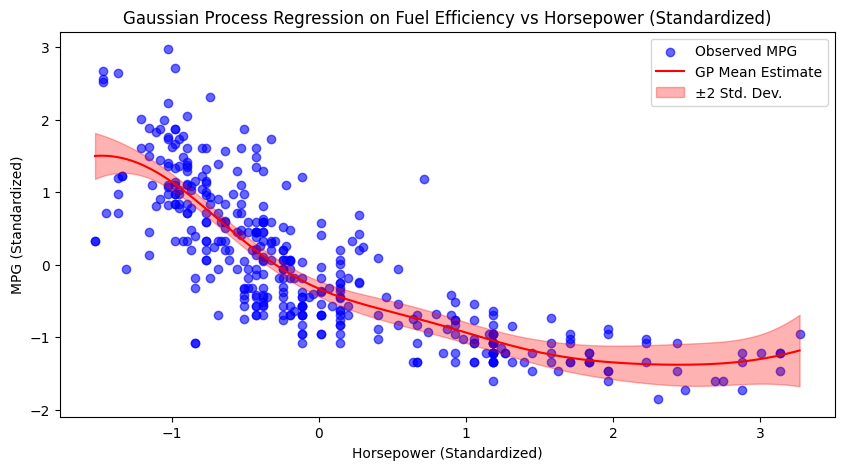

In [ ]:
import pymc as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = sns.load_dataset("mpg").dropna()  # Drop missing values

# Define features
X = df["horsepower"].values.reshape(-1, 1)  # Horsepower as input
y = df["mpg"].values  # MPG as target

# Standardize both X and y
X = (X - np.mean(X)) / np.std(X)
y = (y - np.mean(y)) / np.std(y)

# Define Gaussian Process Model
with pm.Model() as gp_model:
    mean_func = pm.gp.mean.Constant(c=0)  # Constant mean function
    kernel = pm.gp.cov.ExpQuad(1, ls=1.0)  # Exponential Quadratic Kernel

    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=kernel)
    sigma = pm.HalfNormal("sigma", 1.0)  # Observation noise

    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)

    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.9)

# Make predictions over new horsepower values
X_new = np.linspace(X.min(), X.max(), 200)[:, None]
with gp_model:
    mu, var = gp.predict(X_new, point=trace.posterior.mean(dim=["chain", "draw"]), diag=True)
    sd = np.sqrt(var)

# Plot results on standardized scale
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Observed MPG", alpha=0.6, color="blue")  # Original observations
plt.plot(X_new, mu, label="GP Mean Estimate", color="red")  # GP predictions
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, alpha=0.3, color="red", label="±2 Std. Dev.")
plt.title("Gaussian Process Regression on Fuel Efficiency vs Horsepower (Standardized)")
plt.xlabel("Horsepower (Standardized)")
plt.ylabel("MPG (Standardized)")
plt.legend()
plt.show()


- Using the MPG dataset from seaborn with X as horsepower and Y as miles per gallon (mpg) <br>
- predicting the MPG using the Gaussian Process model for a given horsepower value <br>

# Q3

In [37]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [38]:
%config InlineBackend.figure_format = 'retina'
floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [47]:
# https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html#model-specification

# Load the dataset
data = load_iris()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # Add the target variable

# Convert to binary classification (Setosa vs non-Setosa)
df['binary_target'] = (df['target'] == 0).astype(int)  # Setosa = 1, others = 0

# Inspect the first few rows
print(df.head())

# Define X (features) and Y (binary target)
X = df[data.feature_names].values.astype(floatX)  # Features (all columns except 'target')
Y = df['binary_target'].values.astype(floatX)   # Binary target (0 or 1)


# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=RANDOM_SEED
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  binary_target  
0       0              1  
1       0              1  
2       0              1  
3       0              1  
4       0              1  
Training set shape: (75, 4)
Test set shape: (75, 4)


In [48]:
def construct_nn(batch_size=50):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0]),
    }

    with pm.Model(coords=coords) as neural_network:

        # Define data variables using minibatches
        X_data = pm.Data("X_data", X_train, dims=("obs_id", "train_cols"))
        Y_data = pm.Data("Y_data", Y_train, dims="obs_id")

        # Define minibatch variables
        ann_input, ann_output = pm.Minibatch(X_data, Y_data, batch_size=batch_size)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=X_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


# Create the neural network model
neural_network = construct_nn()

In [51]:

with neural_network:
    approx = pm.fit(n=30_000)

Output()

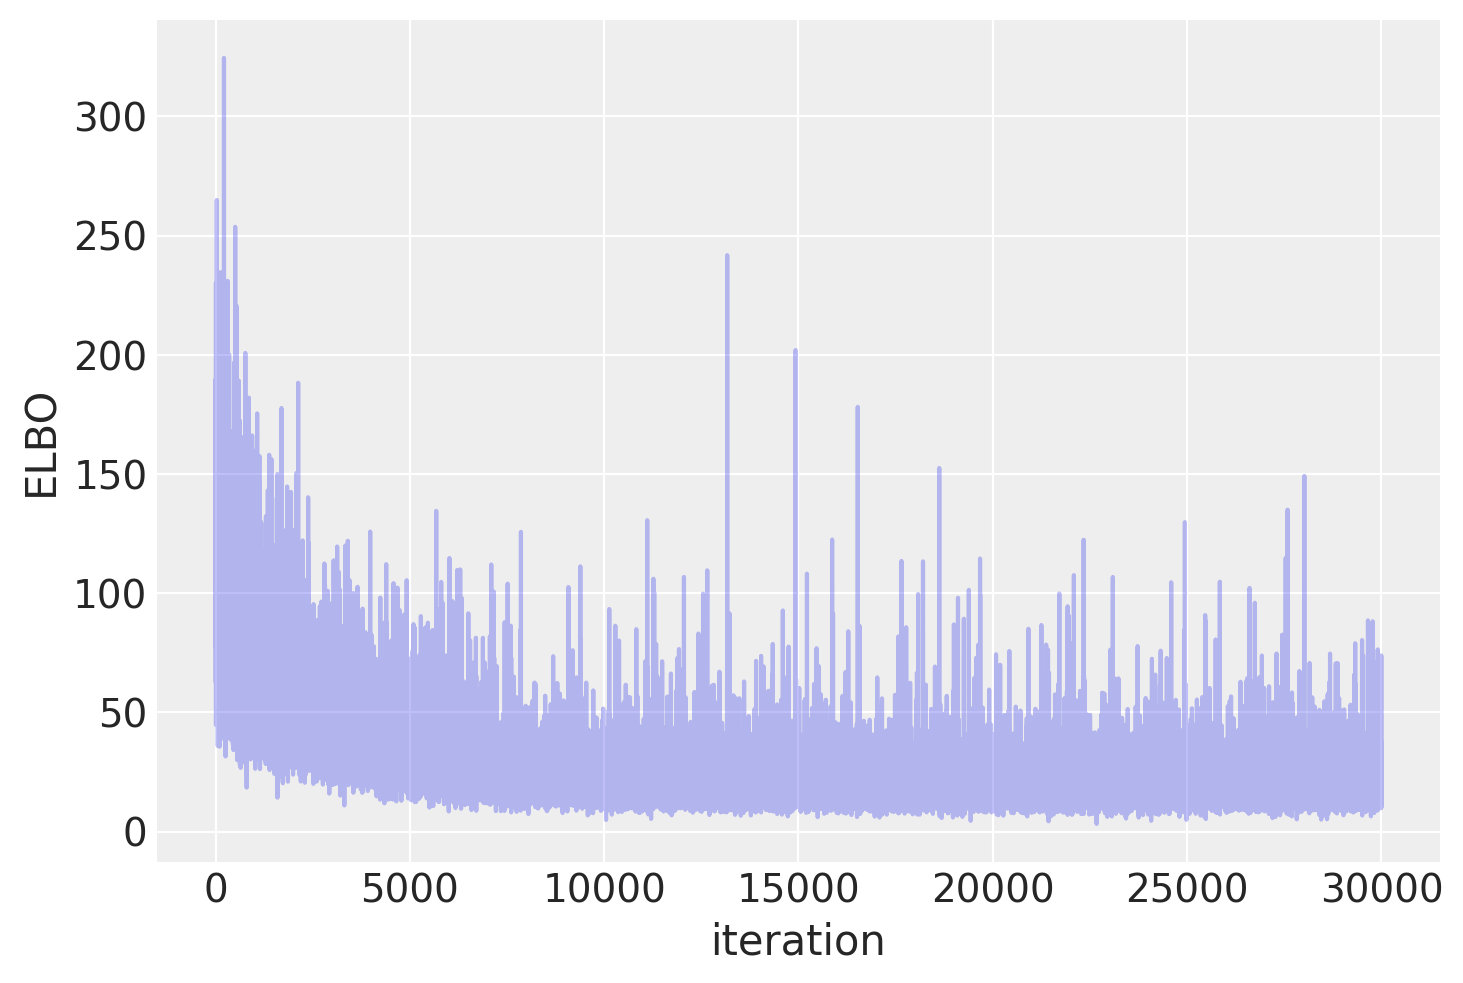

In [57]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [52]:
trace = approx.sample(draws=5000)

In [53]:
def sample_posterior_predictive(X_test, Y_test, trace, n_hidden=5):
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_test.shape[1]),
        "obs_id": np.arange(X_test.shape[0]),
    }
    with pm.Model(coords=coords):

        ann_input = X_test
        ann_output = Y_test

        weights_in_1 = pm.Flat("w_in_1", dims=("train_cols", "hidden_layer_1"))
        weights_1_2 = pm.Flat("w_1_2", dims=("hidden_layer_1", "hidden_layer_2"))
        weights_2_out = pm.Flat("w_2_out", dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli("out", act_out, observed=ann_output)
        return pm.sample_posterior_predictive(trace)


ppc = sample_posterior_predictive(X_test, Y_test, trace)

Output()

In [54]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.5

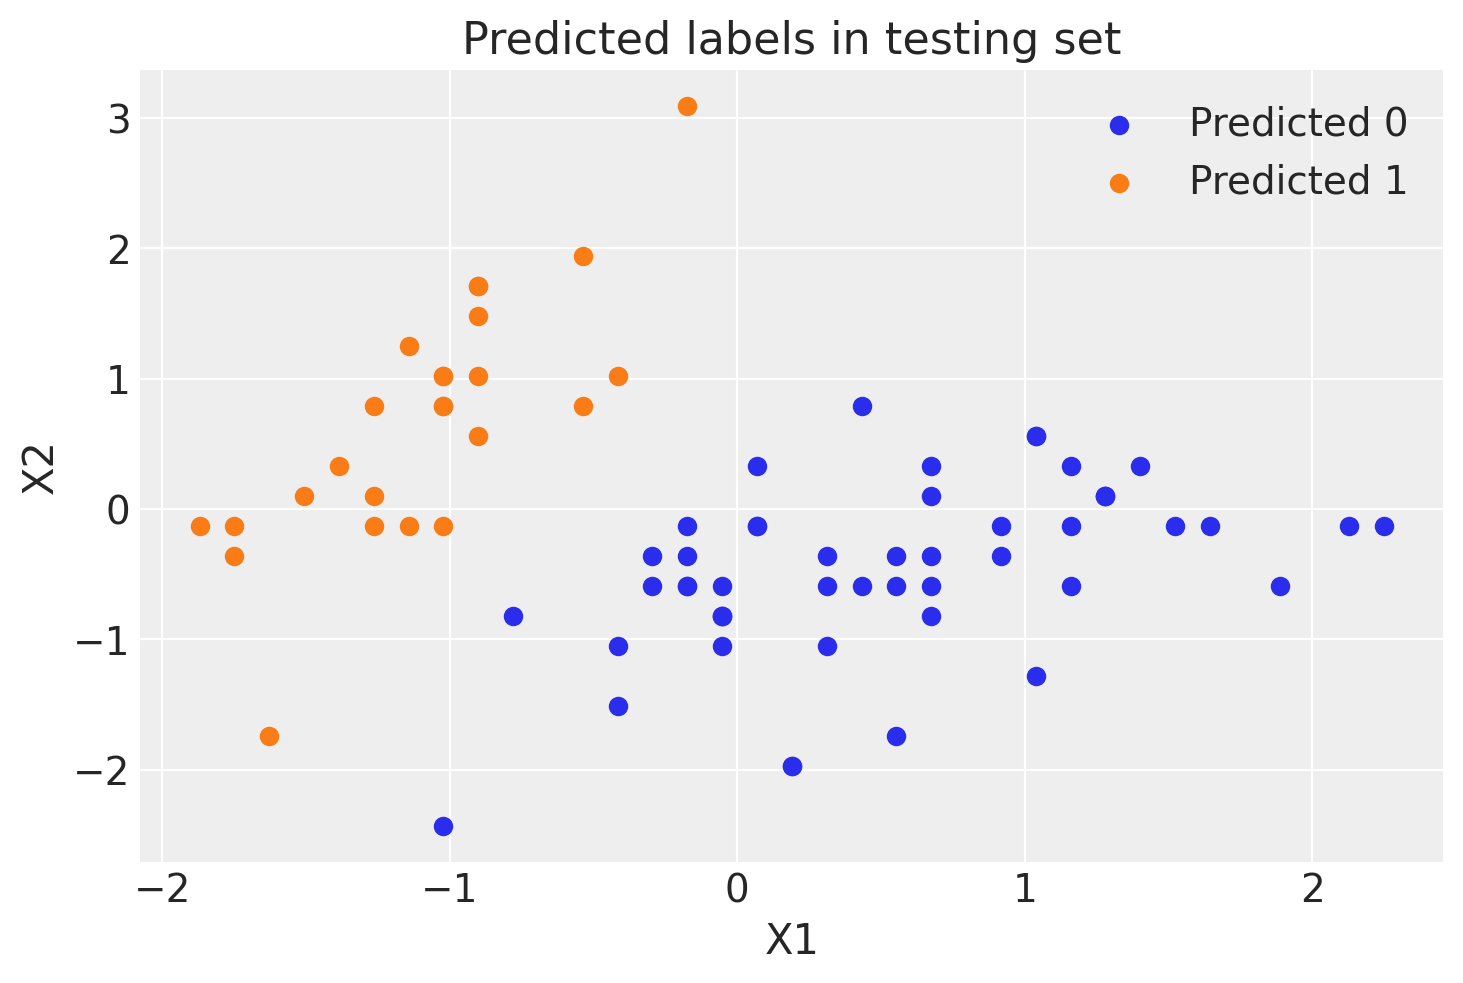

In [55]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0", label="Predicted 0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1", label="Predicted 1")
sns.despine()
ax.legend()
ax.set(title="Predicted labels in testing set", xlabel="X1", ylabel="X2");

In [56]:
print(f"Accuracy = {(Y_test == pred.values).mean() * 100:.2f}%")

Accuracy = 100.00%


- Used the Iris dataset
- Features (X): Sepal length, sepal width, petal length, petal width.
- Target (Y): Binary target (Setosa vs. non-Setosa).

